In [1]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style = "fivethirtyeight"
import json
import numpy as np
from os import listdir
import pymongo

import re
import itertools
import spacy
from spacy.lang.en import English
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import pickle

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Data from MongoDB Server

In [2]:
# Creates a MongoDB Database
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
mydb = myclient['presidential_debates_db']
debates_collection = mydb['debates_collections']
mydb.get_collection_names

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'presidential_debates_db'), 'get_collection_names')

In [3]:
# Call the corpus from database
query_candidates = debates_collection.find( { "$or": [ { "speaker": "Democrat" }, { "speaker": "Republican" } ] } )
candidate_df = pd.DataFrame(list(query_candidates))
candidate_df["party"]= candidate_df["speaker"].apply(lambda y: 0 if y=="Republican" else 1)

### Spacy

In [4]:
# Import the English language class with nlp object
nlp = spacy.load("en_core_web_md")

In [5]:
def lemmatizer(doc):
    doc = [token.lemma_ for token in doc if (token.is_alpha)]
    doc = u' '.join(doc)
    return nlp.make_doc(doc)

In [6]:
# Adds stopwords to spacy's default list of stopwords
def add_stopwords(word_list):
    for word in word_list:
        nlp.Defaults.stop_words.add(word)
        nlp.vocab[word].is_stop = True

In [7]:
# Converts doc to text
def to_text(doc):
#     return [token.text for token in doc if not token.is_stop]
    return u" ".join([token.text for token in doc if not token.is_stop])

In [9]:
nlp.add_pipe(lemmatizer, after='ner')
nlp.add_pipe(to_text, last=True)
print(nlp.pipe_names)

['tagger', 'parser', 'ner', 'lemmatizer', 'to_text']


In [65]:
candidate_df.sample(50)

,_id,line,line_num,name,speaker,party,docs
3459,5d38c31bf997b1856fe65ea6,Donald Trump’s son says that the Trump organiz...,2016-10-04-406,KAINE:,Democrat,1,son organization
945,5d38c31bf997b1856fe64d27,I want to think that they’re going to be able ...,1992-10-15-119,BUSH:,Republican,0,want think able afford education think importa...
2045,5d38c31bf997b1856fe654f8,But I love teachers. But I want to get our pri...,2012-10-22-194,ROMNEY:,Republican,0,love teacher want private sector grow know
3591,5d38c31bf997b1856fe65fa6,On November second all of you will make a very...,1976-09-23-92,MR. FORD:,Republican,0,November second important decision major issue...
2079,5d38c31bf997b1856fe65550,I’m not so sure that it means steadily higher ...,1980-10-28-81,MR. REAGAN:,Republican,0,sure mean steadily high fuel cost believe nati...
1566,5d38c31bf997b1856fe651c0,… of language—well…,2016-10-19-118,CLINTON:,Democrat,1,language
226,5d38c31bf997b1856fe6486d,"Yeah, sure.",2012-10-11-16,BIDEN:,Democrat,1,yeah sure
1480,5d38c31bf997b1856fe6511d,"Well, I don’t believe it would be appropriate ...",1992-10-19-161,BUSH:,Republican,0,believe appropriate president suggest banking ...
2762,5d38c31bf997b1856fe65a4f,"Well, Warren would be a pretty good choice — W...",2008-10-07-11,OBAMA:,Democrat,1,Warren pretty good choice Warren Buffett suppo...
1371,5d38c31bf997b1856fe65020,"Let me finish. Under my plan, if you make — th...",2000-10-17-59,BUSH:,Republican,0,let finish plan wealthy people pay taxis today...


In [40]:
candidate_df['docs'].describe()

count     4110
unique    3681
top           
freq       154
Name: docs, dtype: object

In [67]:
candidate_df[candidate_df['docs'].duplicated()]

,_id,line,line_num,name,speaker,party,docs
116,5d38c31bf997b1856fe6479f,I supported that.,2000-10-11-41,GORE:,Democrat,1,support
231,5d38c31bf997b1856fe64877,Absolutely.,2012-10-11-26,RYAN:,Republican,0,absolutely
267,5d38c31bf997b1856fe648ae,Yeah.,2012-10-11-81,BIDEN:,Democrat,1,yeah
269,5d38c31bf997b1856fe648b0,Yeah.,2012-10-11-83,BIDEN:,Democrat,1,yeah
331,5d38c31bf997b1856fe648fa,Absolutely.,2012-10-11-157,RYAN:,Republican,0,absolutely
343,5d38c31bf997b1856fe64908,Martha…,2012-10-11-171,BIDEN:,Democrat,1,Martha
365,5d38c31bf997b1856fe6492b,Look…,2012-10-11-206,BIDEN:,Democrat,1,look
386,5d38c31bf997b1856fe64941,Republicans and Democrats…,2012-10-11-228,RYAN:,Republican,0,Republicans Democrats
394,5d38c31bf997b1856fe64949,And you saw what happened.,2012-10-11-236,BIDEN:,Democrat,1,happen
421,5d38c31bf997b1856fe6496f,"Right, OK.",2012-10-11-274,RYAN:,Republican,0,right ok


In [10]:
raw_lines = candidate_df["line"].tolist()

In [17]:
docs = list(nlp.pipe(raw_lines))
docs

['think great difference Mashek view reason think effective team believe firmly leadership turn country agree economic program come office inflation percent interest wipe single American percent believe productivity saving despair fact leadership country tell people malaise president turn step way course continue kind program bring America America People work Monad understand new enthusiasm country America new strong leadership know answer problem raise everybody taxis look right lens San Francisco raise taxis lot experience sure ahead remember statement Lyndon look party people support hey paint tail white run antelope lot democratic white tail run antelope single Democrat introduce tax bill Congress course support president economic program support sure concept vice presidency jump away year time trust friendship feel uncomfortable',
 'owe president judgment owe loyalty president United States look shoulder wonder vice president support difference understand change position tuition t

In [16]:
stop_list = ['uh', 'oh', 'Mr', 'Ms', 'Miss', '-PRON-', 
             'Vice', 'President', 'Senator', 'Governor', 'Secretary', 'Congressman', 'Congresswoman',
             'Clintom', 'Kaine', 'Obama', 'Biden', 'Kerry', 'Edwards', 'Gore', 'Lieberman', 'Dukakis',
             'Bentsen', 'Mondale', 'Ferraro', 'Carter', 'Kennedy', 'Johnson', 'Trump', 'Pence', 'Romney', 
             'Ryan', 'McCain', 'Palin', 'Bush', 'Cheney', 'Dole', 'Kemp', 'Quayle', 'Reagan', 'Ford', 
             'Dole', 'Nixon', 'Perot', 'Stockdale', 'Hillary', 'Donald', 'John', 'George', 'Joe' 'Bob',
             'Jimmy', 'Ronald', ]
add_stopwords(stop_list)

In [18]:
candidate_df["docs"] = docs

In [60]:
candidate_df = candidate_df.drop(candidate_df[(candidate_df["docs"]=='')|(candidate_df["docs"]=='yes')|
                                              (candidate_df["docs"]=='no')|(candidate_df["docs"]=='thank')].index)

## Baseline Model

In [61]:
# Splits the data into a training and testing set
X = candidate_df['docs']
y = candidate_df['party']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=120)

In [62]:
log_clf = Pipeline([('tfidf', TfidfVectorizer()), ('log', LogisticRegressionCV())])

In [63]:
log_clf.fit(X_train, y_train)

/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ericma/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/ericma/anacond

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...    random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0))])

Baseline Accuracy score:  0.6805696846388606
Baseline Scores: 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       518
           1       0.67      0.65      0.66       465

   micro avg       0.68      0.68      0.68       983
   macro avg       0.68      0.68      0.68       983
weighted avg       0.68      0.68      0.68       983

Confusion Matrix, without normalization
[[369 149]
 [165 300]]


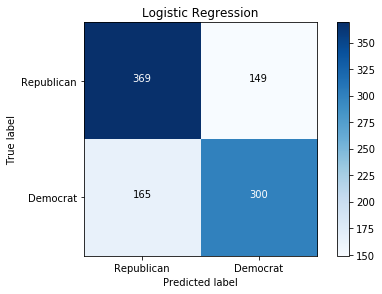

In [64]:
y_pred_log = log_clf.predict(X_test)
baseline = accuracy_score(y_test, y_pred_log)
print('Baseline Accuracy score: ', accuracy_score(y_test, y_pred_log))
print('Baseline Scores: ')
print(classification_report(y_test, y_pred_log))
cm = confusion_matrix(y_test, y_pred_log)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Logistic Regression',
                          cmap=plt.cm.Blues)

In [ ]:
# Saving: Pickling the model
with open('basemodel.pickle', 'wb') as f:
    pickle.dump(log_clf, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading Pickle
with open('basemodel.pickle', 'rb') as file:
    log_clf = pickle.load(file)

## Classification Models

In [31]:
# K Nearest Neighbors
pipe_knn = Pipeline([('tfidf', TfidfVectorizer()), ('knn', KNeighborsClassifier())])
#use gridsearch to test all values for n_neighbors
param_grid_knn = {'knn__n_neighbors': list(range(5, 26, 2)), 'knn__n_jobs':[-1]}

gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=param_grid_knn,
            scoring='accuracy',
            cv=9, return_train_score = True)

gs_knn.fit(X_train, y_train)
# Best params
print('Best params: ', gs_knn.best_params_)

Best params:  {'knn__n_jobs': -1, 'knn__n_neighbors': 11}


Best accuracy:  0.4980544747081712
Confusion Matrix, without normalization
[[249 316]
 [200 263]]


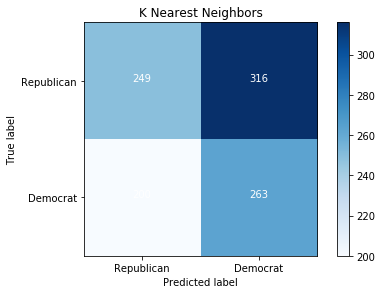

In [32]:
y_pred_knn = gs_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('Best accuracy: ', accuracy_knn)
cm = confusion_matrix(y_test, y_pred_knn)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='K Nearest Neighbors',
                          cmap=plt.cm.Blues)

In [37]:
# Random Forest
pipe_rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])

# Set grid search params
param_grid_forest = [ 
  {'rf__n_estimators': [120],
   'rf__criterion': ['entropy', 'gini'], 
   'rf__max_depth': list(range(1,10)),  
   'rf__min_samples_leaf':list(range(1,10)),  
   'rf__min_samples_split':list(range(2,10)),
   'rf__n_jobs':[-1]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=5, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best params
print('Best params: ', gs_rf.best_params_)

Best params:  {'rf__criterion': 'gini', 'rf__max_depth': 9, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 120, 'rf__n_jobs': -1}


Best accuracy:  0.6498054474708171
Confusion Matrix, without normalization
[[533  32]
 [328 135]]


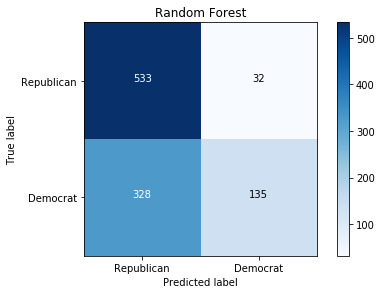

In [38]:
y_pred_rf = gs_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Best accuracy: ', accuracy_rf)
cm = confusion_matrix(y_test, y_pred_rf)
classes = ['Republican', 'Democrat']
plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Random Forest',
                          cmap=plt.cm.Blues)

In [39]:
with open('rfmodel.pickle', 'wb') as f:
    pickle.dump(gs_rf, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('rfmodel.pickle', 'rb') as file:
    gs_rf = pickle.load(file)